# Setup

In [1]:
# Packages -----------------------------------------------#

# Data Analysis
import xarray as xr
import numpy as np
import pandas as pd
import metpy.calc as mpcalc
import matplotlib.dates as dates

# Plotting
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from scipy.ndimage import gaussian_filter
from matplotlib.lines import Line2D
import datetime as dt

# make sure the figures plot inline rather than at the end
%matplotlib inline

# get data from tigress
ds_CD = xr.open_dataset('../data/CD/CD.nc')


In [2]:
# get rid of data before 1958 - to get right coastlines for iod phases not total data / compare with 
start_time = '1994-01-01'
end_time = '2020-02-07'
time_slice = slice(start_time, end_time)

TCD = ds_CD.TCD_anom.sel(time=time_slice)
OCD = ds_CD.OCD_anom.sel(time=time_slice)
lat = ds_CD.lat.sel(time=time_slice)
lon = ds_CD.lon.sel(time=time_slice)
times = ds_CD.time.sel(time=time_slice)

# TCD = ds_CD.TCDA_AWG
# OCD = ds_CD.OCDA_AWG
# lat = ds_CD.lat
# lon = ds_CD.lon
# times = ds_CD.time
    
# binning for one variable ------------------------------------------------------------#
def latlonbin(invar,lat,lon,bounds,binwidth):
    import numpy as np
    
    # create a pandas dataframe
    df = pd.DataFrame(dict(
            invar = np.array(invar),
            lat= np.array(lat),
            lon= np.array(lon),
        ))

    # create 1 degree bins
    latedges = np.arange(bounds[2]-(binwidth/2),bounds[3]+(binwidth/2),binwidth)
    lat_inds = list(range(len(latedges)-1))

    lonedges = np.arange(bounds[0]-(binwidth/2),bounds[1]+(binwidth/2),binwidth)
    lon_inds = list(range(len(lonedges)-1))

    latbins = latedges[1:]-(binwidth/2)
    lonbins = lonedges[1:]-(binwidth/2)

    df['latedges'] = pd.cut(lat, latedges)
    df['lonedges'] = pd.cut(lon, lonedges)
    df['latbins_ind'] = pd.cut(lat, latedges,labels = lat_inds)
    df['lonbins_ind'] = pd.cut(lon, lonedges,labels = lon_inds)
    df['lat_lon_indx']=df.groupby(['latbins_ind', 'lonbins_ind']).ngroup()
    grouped = df.groupby(['latbins_ind', 'lonbins_ind'])

    invar_BINNED = np.zeros((len(latbins),len(lonbins)), dtype=np.ndarray)
    invar_BINNED[:] = np.nan

    invar_binned_ave = np.zeros((len(latbins),len(lonbins)), dtype=np.ndarray)
    invar_binned_ave[:] = np.nan
    
    invar_bincounts = np.zeros((len(latbins),len(lonbins)), dtype=np.ndarray)
    invar_bincounts[:] = np.nan


    #extract the data for each group
    for name, group in grouped:
        i = np.array(group.latbins_ind)
        j = np.array(group.lonbins_ind)

        invar_BINNED[i[0],j[0]] = group.invar

        invar_binned_ave[i[0],j[0]] = np.nanmean(group.invar)   
        
        invar_bincounts[i[0],j[0]] = len(group.invar[np.isfinite(group.invar)]) 

    return np.array(invar_binned_ave,dtype = float),np.array(invar_bincounts,dtype = float),latbins,lonbins

bounds = [35,120,-20,30]
binwidth = 5

TCD_binned_ave,TCD_bncts,latbins,lonbins = latlonbin(TCD,lat,lon,bounds,binwidth)

/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:63: RuntimeWarning: Mean of empty slice


In [3]:
def add_land(ax,bounds):
    from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
    ax.add_feature(cfeature.LAND,color='gray',zorder = 0)
    ax.background_patch.set_facecolor('k')
    ax.coastlines(resolution='110m',zorder = 0)
    g = ax.gridlines(draw_labels=True,alpha=0)
    g.xlabels_top = False
    g.ylabels_right = False
    g.xlabel_style = {'size': 15}
    g.ylabel_style = {'size': 15}
    g.xformatter = LONGITUDE_FORMATTER
    g.yformatter = LATITUDE_FORMATTER
    ax.axes.axis('tight')
    ax.set_extent(bounds, crs=ccrs.PlateCarree())
    return None 

def find_coast(arr):
    import itertools
    
    # create empty lists to add row and col info to
    rowind = []
    colind = []

    # create an array of indices
    rows = np.arange(arr.shape[0])
    cols = np.arange(arr.shape[1])

    # find if the sum of a block around a point is a nan (meaning one of the values at least must have been a nan)
    for row,col in itertools.product(rows,cols):
        rowcond = (np.isnan(np.sum(arr[max(0,row-1):min(arr.shape[0],row+2),col])))
        colcond = (np.isnan(np.sum(arr[row,max(0,col-1):min(arr.shape[1],col+2)])))

        if  (~np.isnan(arr[row,col])) & (rowcond | colcond):
            rowind.append(rows[row].tolist())
            colind.append(cols[col].tolist())
    
    return np.array(rowind), np.array(colind)

# Find Coastlines

Text(0.5, 1.0, 'Unordered Stations')

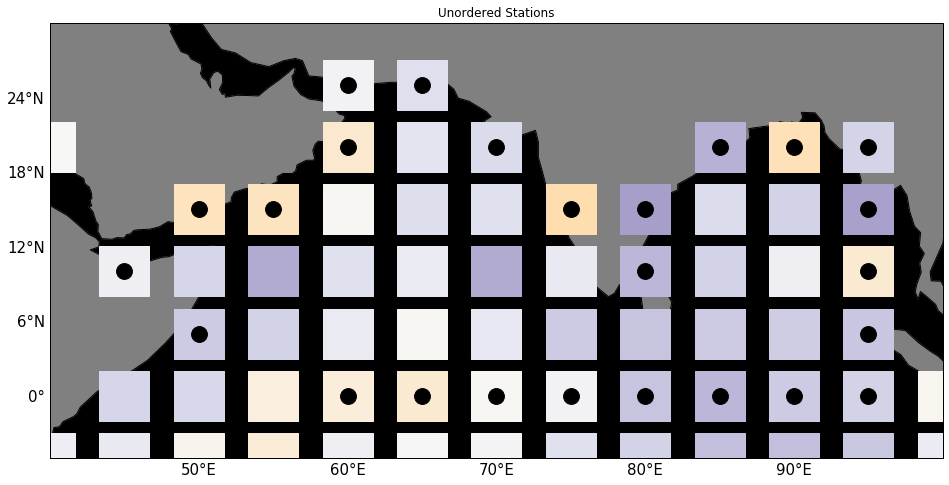

In [4]:
# ------------------------------------------------------------#
# block out a few places that you don't want to include
# ------------------------------------------------------------#

mask = TCD_binned_ave
xx,yy = np.meshgrid(lonbins,latbins)


# set Gulfs to Nans
mask = np.where(~((yy>18) & (xx<60)),mask,np.nan)

# # AS inlets
mask = np.where(~((yy>21.5) & (yy<22) & (xx>72) & (xx<73)),mask,np.nan)

mask = np.where(~((yy>-2) & (yy<12) & (xx>97) & (xx<101)),mask,np.nan)

# # set Gulfs to Nans
# mask = np.where(~(xx<50),mask,np.nan)

# # AS inlets
# mask = np.where(~((yy>24) & (xx<60)),mask,np.nan)

# equator
mask = np.where(~(yy<0),mask,np.nan)
# ------------------------------------------------------------#
# locate points along the BoB and AS
# ------------------------------------------------------------#

sta_latinds_unord, sta_loninds_unord = find_coast(np.array(mask))

# ------------------------------------------------------------#
# Remove Manually some other points
# ------------------------------------------------------------#

sta_latinds_unord = sta_latinds_unord[3:]
sta_loninds_unord = sta_loninds_unord[3:]

# # ------------------------------------------------------------#
# # Add in points
# # ------------------------------------------------------------#

# sta_latinds_unord = np.append(sta_latinds_unord,9)
# sta_loninds_unord = np.append(sta_loninds_unord,6)

sta_latinds_unord = np.append(sta_latinds_unord,6)
sta_loninds_unord = np.append(sta_loninds_unord,9)

# sta_latinds_unord = np.append(sta_latinds_unord,6)
# sta_loninds_unord = np.append(sta_loninds_unord,8)

# ------------------------------------------------------------#
# Plot
# ------------------------------------------------------------#
cmin = -0.2
cmax = 0.2
levels = np.linspace(cmin, cmax, 10)

# Start figure
fig = plt.figure(figsize=(16, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
add_land(ax,[40,100,-5,30])
xx,yy = np.meshgrid(lonbins,latbins)
xx = xx.flatten()
yy = yy.flatten()
p2 = plt.scatter(xx,yy,c = TCD_binned_ave.flatten(),marker='s',
                      s = 2500,cmap=plt.cm.PuOr_r,vmin=-30,vmax=30,transform=ccrs.PlateCarree())
plt.scatter(lonbins[sta_loninds_unord],latbins[sta_latinds_unord],
            s = 1000,c='k',marker = '.')
plt.title('Unordered Stations')

No Next Station Found. Returning Previous Stations Only.
(3, 5) [(12, 4)]


Text(0.5, 1.0, 'Stations')

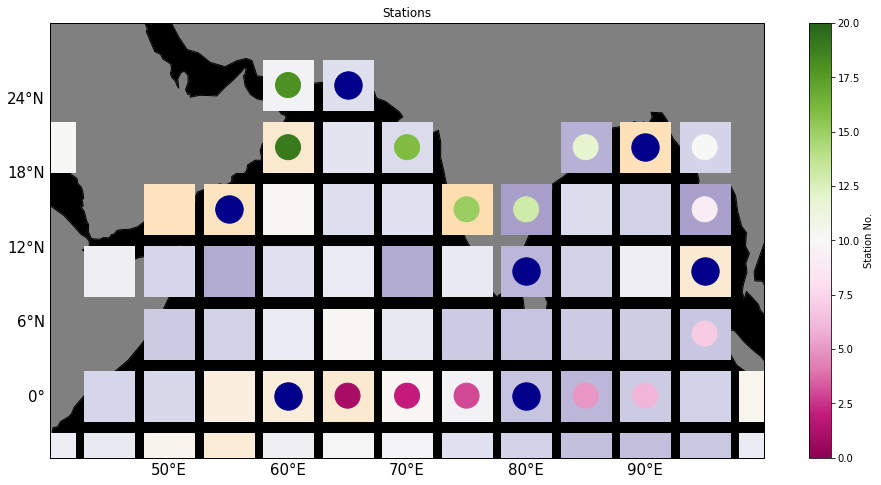

In [5]:
# ------------------------------------------------------------#
# put in the right order
# ------------------------------------------------------------#


def order_coast(loninds,latinds,sta_zero):
    # find based on radius
    zipped_lists = zip(loninds, latinds)
    sorted_pairs = sorted(zipped_lists, reverse=True)

    # sort by lon
    tuples = zip(*sorted_pairs)
    lon_list,lat_list  = [ list(tuple) for tuple in  tuples]

    pos = []
    curr_sta = []
    rem_sta = sorted_pairs
    for i in range(len(lon_list)):
#         print(i)
        if i == 0:
            curr_sta.append(sta_zero)
            rem_sta.remove(sta_zero) 
            prev_sta = sta_zero
        else:
            prev_sta = curr_sta[i-1]

        start_len = len(curr_sta)
        for j,(lo, la) in enumerate(rem_sta):
            next_sta = (rem_sta[j])
            
            diff = tuple(map(lambda l, k: l - k, curr_sta[i], next_sta))
            
            # check uplr first
            if(next_sta != prev_sta) & (all(np.abs(diff) == [0,1])) | (all(np.abs(diff) == [1,0])):
                curr_sta.append(next_sta)
                rem_sta.remove(next_sta) 
                break

            # then check diagonals
            elif (next_sta != prev_sta) & (all(np.abs(diff) == [1,1])):
                curr_sta.append(next_sta)
                rem_sta.remove(next_sta) 
                break
                
        if len(curr_sta) == start_len:
            print('No Next Station Found. Returning Previous Stations Only.')
            print(curr_sta[i],rem_sta)
            break
        
    sta_lonind, sta_latind  = map(np.array, zip(*curr_sta))
    
    return sta_lonind, sta_latind

#initial station
sta_zero = (sta_loninds_unord[0],sta_latinds_unord[0]) # 98.625, 10.375

#calculate
sta_loninds, sta_latinds =order_coast(sta_loninds_unord,sta_latinds_unord,sta_zero)


# remove last couple points
sta_loninds, sta_latinds = sta_loninds[:-3], sta_latinds[:-3]

# ------------------------------------------------------------#
# identify first stations for EQ, BOB, and AS
# ------------------------------------------------------------#

EQ = 0
JA = 4
sBoB = 8
mBoB = 11
SL = 14
mAS = 17
eAS = 20
loc_list = [EQ,JA,sBoB,mBoB,SL,mAS,eAS]

# ------------------------------------------------------------#
# plot
# ------------------------------------------------------------#
# Start figure
fig = plt.figure(figsize=(16, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
add_land(ax,[40,100,-5,30])
xx,yy = np.meshgrid(lonbins,latbins)
xx = xx.flatten()
yy = yy.flatten()
p2 = plt.scatter(xx,yy,c = TCD_binned_ave.flatten(),marker='s',
                      s = 2500,cmap=plt.cm.PuOr_r,vmin=-30,vmax=30,transform=ccrs.PlateCarree())
p =plt.scatter(lonbins[sta_loninds],latbins[sta_latinds],
            s = 2500,c=np.arange(len(sta_latinds)),marker = '.',cmap =plt.cm.PiYG) 
plt.scatter(lonbins[sta_loninds[loc_list]],latbins[sta_latinds[loc_list]],
            s = 3000,c='darkblue',marker = '.')
plt.colorbar(p,label = 'Station No.')

plt.title('Stations')

# plt.savefig('../figures/stations-SLA-along-coast.png', dpi=300, bbox_inches='tight')

# Group Into IOD Phases

In [6]:
# load DMI data
ds_DMI= xr.open_dataset('../data/DMI/dmi_processed.nc')
ds_DMI

# lists of positive iod years for now taken from sources above 1994-2018 unsure after 2016
posIODyears = list(np.array(ds_DMI.pos_IOD_years))
negIODyears = list(np.array(ds_DMI.neg_IOD_years))
neuIODyears = list(np.array(ds_DMI.neu_IOD_years))

In [7]:
# binning for one variable ------------------------------------------------------------#
def latlonbin_month(invar,lat,lon,month,bounds,binwidth):
    import numpy as np
    
    # create a pandas dataframe
    df = pd.DataFrame(dict(
            invar = np.array(invar),
            lat= np.array(lat),
            lon= np.array(lon),
            month = month
        ))

    # create 1 degree bins
    latedges = np.arange(bounds[2]-(binwidth/2),bounds[3]+(binwidth/2),binwidth)
    lat_inds = list(range(len(latedges)-1))

    lonedges = np.arange(bounds[0]-(binwidth/2),bounds[1]+(binwidth/2),binwidth)
    lon_inds = list(range(len(lonedges)-1))

    latbins = latedges[1:]-(binwidth/2)
    lonbins = lonedges[1:]-(binwidth/2)

    df['latedges'] = pd.cut(lat, latedges)
    df['lonedges'] = pd.cut(lon, lonedges)
    df['latbins_ind'] = pd.cut(lat, latedges,labels = lat_inds)
    df['lonbins_ind'] = pd.cut(lon, lonedges,labels = lon_inds)
    df['lat_lon_indx']=df.groupby(['latbins_ind', 'lonbins_ind']).ngroup()
    grouped = df.groupby(['latbins_ind', 'lonbins_ind'])

    invar_BINNED = np.zeros((12,len(latbins),len(lonbins)), dtype=np.ndarray)
    invar_BINNED[:] = np.nan

    invar_binned_ave = np.zeros((12,len(latbins),len(lonbins)), dtype=np.ndarray)
    invar_binned_ave[:] = np.nan
    
    invar_bincounts = np.zeros((12,len(latbins),len(lonbins)), dtype=np.ndarray)
    invar_bincounts[:] = np.nan
    
    #extract the data for each group
    for name,group in grouped:
        i = np.array(group.latbins_ind)
        j = np.array(group.lonbins_ind)
        
        #group a second time by month
        mon_grouped = group.groupby(['month'])
        
        for mm,mon_group in mon_grouped:
#             if mm == 1:
#                 print(mon_group)

            invar_BINNED[mm-1,i[0],j[0]] = mon_group.invar

            invar_binned_ave[mm-1,i[0],j[0]] = np.nanmean(mon_group.invar)   

            invar_bincounts[mm-1,i[0],j[0]] = len(mon_group.invar[np.isfinite(mon_group.invar)]) 


    return np.array(invar_binned_ave,dtype = float),np.array(invar_bincounts,dtype = float),latbins,lonbins

In [8]:
posIODyears

[1961, 1963, 1967, 1972, 1977, 1982, 1994, 1997, 2006, 2012, 2015, 2018, 2019]

In [9]:
# average over the positive IOD years -------------------------------------------# 
mon_data = []
mon_lat = []
mon_lon = []
mon_time = []
mon_month = []

for ii,year in enumerate(posIODyears):
    start_time = str(year) + '-06-01'
    end_time = str(year+1) + '-05-31'
    time_slice = slice(start_time, end_time)
    mon_data.extend(np.array(ds_CD.TCD_anom.sel(time=time_slice)))
    mon_lat.extend(np.array(ds_CD.lat.sel(time=time_slice)))
    mon_lon.extend(np.array(ds_CD.lon.sel(time=time_slice)))
    mon_time.extend(np.array(ds_CD.time.sel(time=time_slice)))
    t = ds_CD.time.sel(time=time_slice)
    mon_month.extend(np.array(t.time.dt.month))


bounds = [35,120,-20,30]
    
# bin for each month
posIOD_TCD,posIOD_TCD_bncts,latbins,lonbins = latlonbin_month(mon_data,mon_lat,mon_lon,mon_month,bounds,5)

# average over the negative IOD years -------------------------------------------# 
mon_data = []
mon_lat = []
mon_lon = []
mon_time = []
mon_month = []

for ii,year in enumerate(negIODyears):
    start_time = str(year) + '-06-01'
    end_time = str(year+1) + '-05-31'
    time_slice = slice(start_time, end_time)
    mon_data.extend(np.array(ds_CD.TCD_anom.sel(time=time_slice)))
    mon_lat.extend(np.array(ds_CD.lat.sel(time=time_slice)))
    mon_lon.extend(np.array(ds_CD.lon.sel(time=time_slice)))
    mon_time.extend(np.array(ds_CD.time.sel(time=time_slice)))
    t = ds_CD.time.sel(time=time_slice)
    mon_month.extend(np.array(t.time.dt.month))


bounds = [35,120,-20,30]
    
# bin for each month
negIOD_TCD,negIOD_TCD_bncts,latbins,lonbins = latlonbin_month(mon_data,mon_lat,mon_lon,mon_month,bounds,5)

# average over the neutral IOD years -------------------------------------------# 
mon_data = []
mon_lat = []
mon_lon = []
mon_time = []
mon_month = []

for ii,year in enumerate(neuIODyears):
    start_time = str(year) + '-06-01'
    end_time = str(year+1) + '-05-31'
    time_slice = slice(start_time, end_time)
    mon_data.extend(np.array(ds_CD.TCD_anom.sel(time=time_slice)))
    mon_lat.extend(np.array(ds_CD.lat.sel(time=time_slice)))
    mon_lon.extend(np.array(ds_CD.lon.sel(time=time_slice)))
    mon_time.extend(np.array(ds_CD.time.sel(time=time_slice)))
    t = ds_CD.time.sel(time=time_slice)
    mon_month.extend(np.array(t.time.dt.month))


bounds = [35,120,-20,30]
    
# bin for each month
neuIOD_TCD,neuIOD_TCD_bncts,latbins,lonbins = latlonbin_month(mon_data,mon_lat,mon_lon,mon_month,bounds,5)

/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: Mean of empty slice
/home/jennap/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: Mean of empty slice


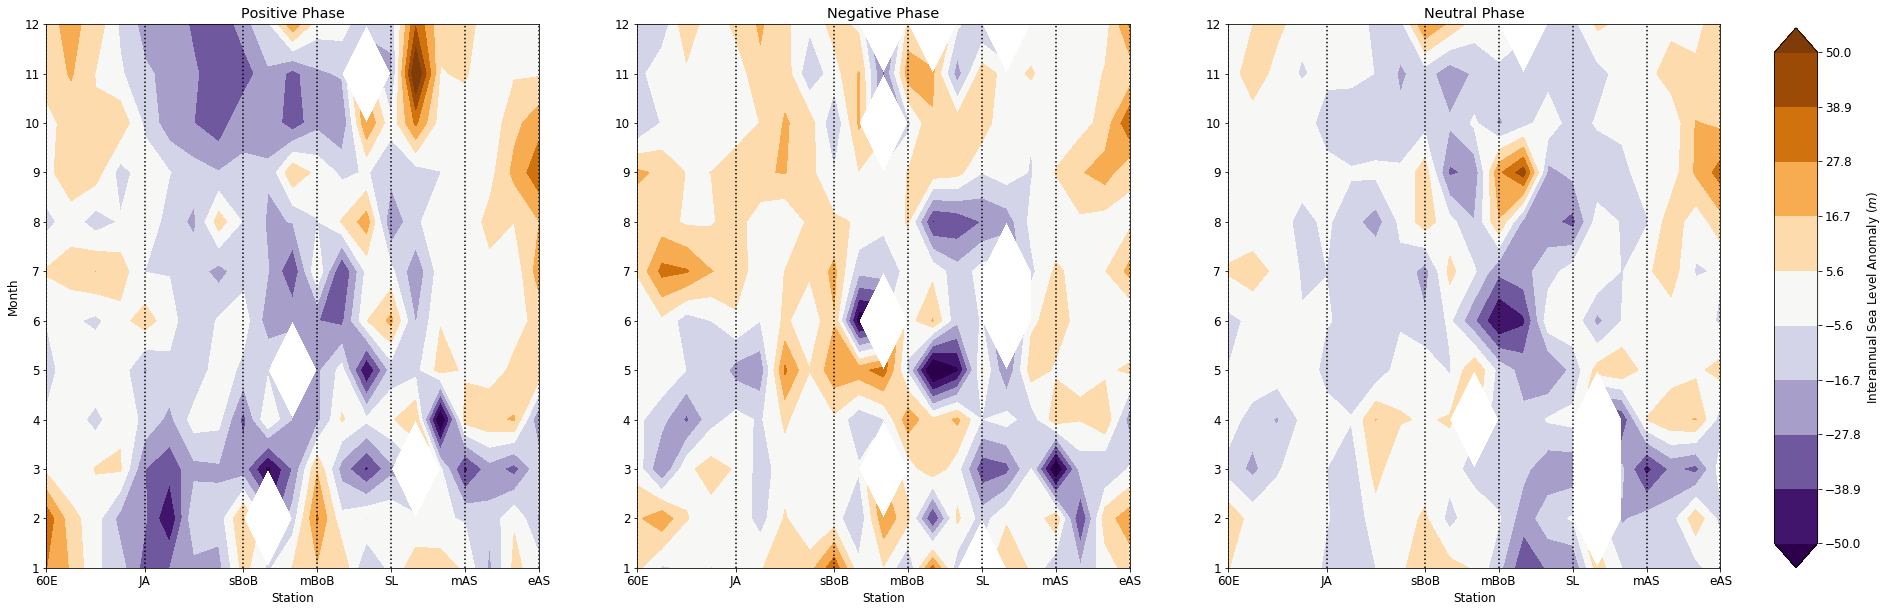

In [10]:
IODphases = list([posIOD_TCD,negIOD_TCD,neuIOD_TCD])
titles = ['Positive Phase','Negative Phase', 'Neutral Phase']
plt.rcParams.update({'font.size': 12})

cmin = -50
cmax = 50

fig = plt.figure(figsize=(30, 10))
for ii,phase in enumerate(IODphases):
    
    # Get times and make array of datetime objects
    vtimes =  np.arange(1,13)
    
    data = np.zeros([vtimes.shape[0],sta_loninds.shape[0]])
#     print(data.shape)
    for jj in range(sta_loninds.shape[0]):
        data[:,jj] = phase[:,sta_latinds[jj],sta_loninds[jj]]

    # colorbar limits
    levels = np.linspace(cmin, cmax, 10)

    # Specify longitude values for chosen domain
    sta = np.arange(len(sta_loninds))

    ax = fig.add_subplot(1,3,ii+1)

    # Plot of chosen variable averaged over latitude and slightly smoothed
    cf = ax.contourf(sta,vtimes,data,levels = levels,cmap=plt.cm.PuOr_r, extend="both")
    for loc in loc_list:
        plt.axvline(x=loc,color = 'k',linestyle = ':')
        
    plt.xlabel('Station')
    if ii == 0:
        plt.ylabel('Month')
    
    plt.title(titles[ii])
#     ax.set_yticklabels(['06','07','08','09','10','11','12','01','02','03', '04', '05'])
    ax.set_xticks(loc_list)
    ax.set_xticklabels(['60E','JA', 'sBoB','mBoB', 'SL', 'mAS','eAS'])
    ax.set_yticks(list(np.arange(1,13)))
    cf.set_clim(cmin, cmax)# reset lims because contourf does weird things.

cbar_ax = fig.add_axes([0.925, 0.125, 0.02, 0.75])
cbar = fig.colorbar(cf,cax=cbar_ax, pad=0.04)
cbar.set_label('Interannual Sea Level Anomaly ($m$)')

# plt.savefig('../figures/seasonal-and-IOD-years-SLA-along-coast-0-25-degree.png', dpi=300, bbox_inches='tight')




Text(0.5, 1.0, 'Stations')

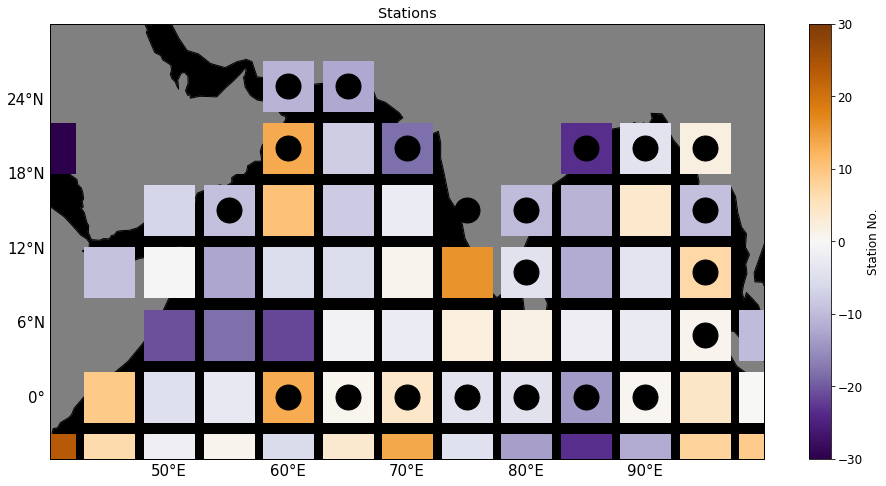

In [11]:

phase = neuIOD_TCD
mon = 2

# Start figure
fig = plt.figure(figsize=(16, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
add_land(ax,[40,100,-5,30])
# plt.scatter(ds_CD.lonbins[sta_loninds[loc_list]],ds_CD.lonbins[sta_latinds[loc_list]],
#             s = 260,c='darkblue',marker = '.')
xx,yy = np.meshgrid(lonbins,latbins)
xx = xx.flatten()
yy = yy.flatten()
p = plt.scatter(xx,yy,c = phase[mon-1,:,:].flatten(),marker='s',s = 2500,cmap=plt.cm.PuOr_r,vmin=-30,vmax=30,transform=ccrs.PlateCarree())
plt.scatter(lonbins[sta_loninds],latbins[sta_latinds],
            s = 2500,c='k',marker = '.') 
plt.colorbar(p,label = 'Station No.')

plt.title('Stations')

In [12]:
plt.rcParams.update({'font.size': 20})
phase = mon_clim_TCD

cmin = 20
cmax = 160


fig = plt.figure(figsize=(14, 14))

# Get times and make array of datetime objects
vtimes = np.arange(1,13)

data = np.zeros([vtimes.shape[0],sta_loninds.shape[0]])
#     print(data.shape)
for jj in range(sta_loninds.shape[0]):
    data[:,jj] = phase[:,sta_latinds[jj],sta_loninds[jj]]

# colorbar limits
levels = np.linspace(cmin, cmax, 10)

# Specify longitude values for chosen domain
sta = np.arange(len(sta_loninds))

ax = fig.add_subplot(1,1,1)

# Plot of chosen variable averaged over latitude and slightly smoothed
cf = ax.contourf(sta,vtimes,data,levels = levels,cmap=plt.cm.PuOr_r, extend="both")
for loc in loc_list:
    plt.axvline(x=loc,color = 'k',linestyle = ':')

plt.xlabel('Station')
if ii == 0:
    plt.ylabel('Month')

# plt.title('Positive Phase')
# ax.set_yticklabels(['06','07','08','09','10','11','12','01','02','03', '04', '05'])
ax.set_xticks(loc_list)
ax.set_xticklabels(['60E','80E', 'sBoB','mBoB', 'SL', 'mAS','eAS'])
ax.set_yticks(list(np.arange(1,13)))
cf.set_clim(cmin, cmax)# reset lims because contourf does weird things.

cbar_ax = fig.add_axes([0.925, 0.125, 0.02, 0.75])
cbar = fig.colorbar(cf,cax=cbar_ax, pad=0.04)
cbar.set_label('Sea Level Anomaly ($m$)')
# plt.savefig('../figures/' + titles_save[ii] +'-SLA-along-coast.png', dpi=300, bbox_inches='tight')


NameError: name 'mon_clim_TCD' is not defined

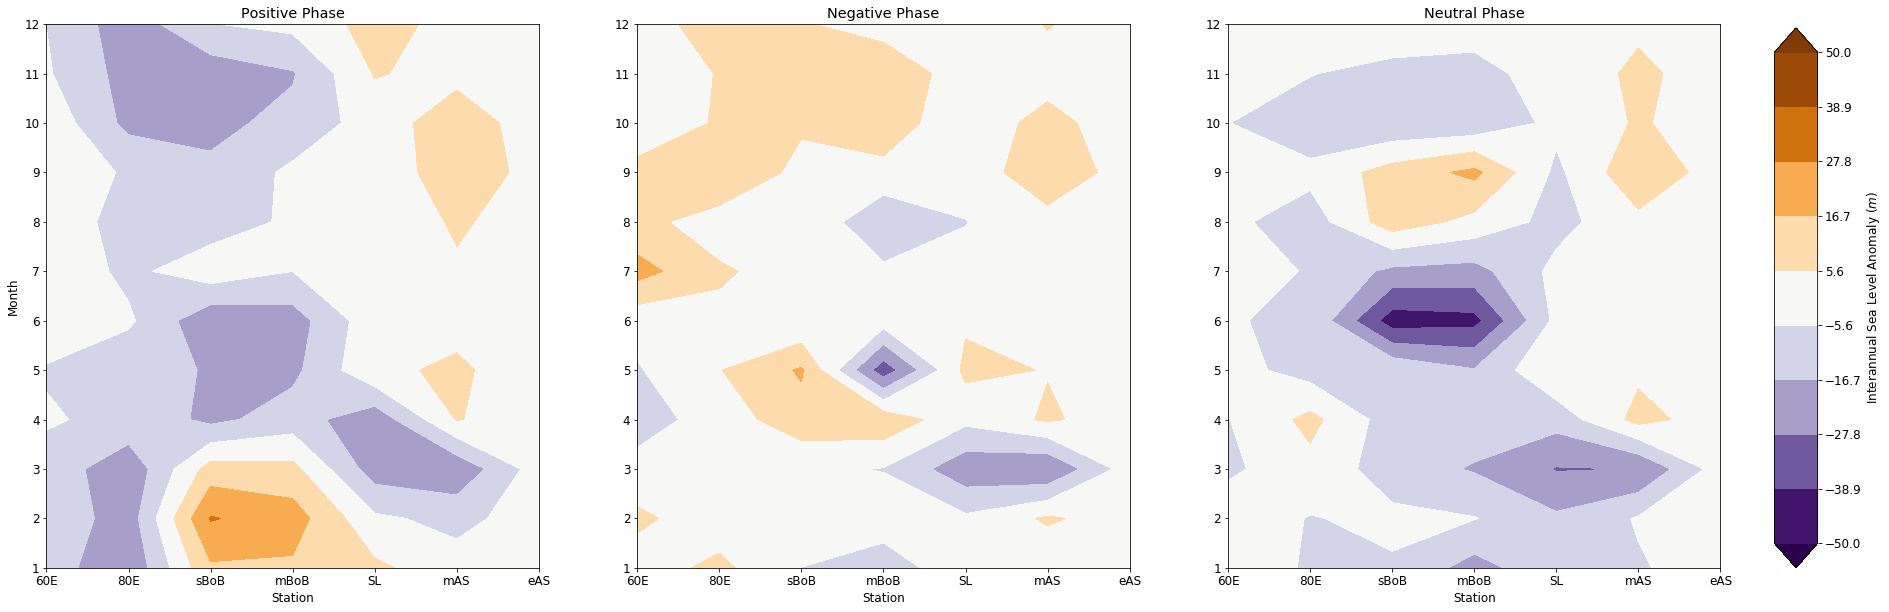

In [13]:
IODphases = list([posIOD_TCD,negIOD_TCD,neuIOD_TCD])
IODbncts = list([posIOD_TCD_bncts,negIOD_TCD_bncts,neuIOD_TCD_bncts])
titles = ['Positive Phase','Negative Phase', 'Neutral Phase']
plt.rcParams.update({'font.size': 12})

cmin = -50
cmax = 50

fig = plt.figure(figsize=(30, 10))
for ii,phase in enumerate(IODphases):
    
    # Get times and make array of datetime objects
    vtimes =  np.arange(1,13)
    
    data = np.zeros([vtimes.shape[0],sta_loninds.shape[0]])
    bncts = np.zeros([vtimes.shape[0],sta_loninds.shape[0]])
    
#     print(data.shape)
    for jj in range(sta_loninds.shape[0]):
        data[:,jj] = phase[:,sta_latinds[jj],sta_loninds[jj]]
        bncts[:,jj] = IODbncts[ii][:,sta_latinds[jj],sta_loninds[jj]]
        
    block_data = np.zeros([vtimes.shape[0],len(loc_list)])
    for ll in range(len(loc_list)-1):
        block_data[:,ll] = np.nansum(data[:,loc_list[ll]:loc_list[ll+1]+1] * bncts[:,loc_list[ll]:loc_list[ll+1]+1],1)/np.nansum(bncts[:,loc_list[ll]:loc_list[ll+1]+1],1)

    # colorbar limits
    levels = np.linspace(cmin, cmax, 10)

    # Specify longitude values for chosen domain
    sta = np.arange(len(loc_list))

    ax = fig.add_subplot(1,3,ii+1)

    # Plot of chosen variable averaged over latitude and slightly smoothed
    cf = ax.contourf(sta,vtimes,block_data,levels = levels,cmap=plt.cm.PuOr_r, extend="both")
#     for loc in loc_list:
#         plt.axvline(x=loc,color = 'k',linestyle = ':')
        
    plt.xlabel('Station')
    if ii == 0:
        plt.ylabel('Month')
    
    plt.title(titles[ii])
#     ax.set_yticklabels(['06','07','08','09','10','11','12','01','02','03', '04', '05'])
#     ax.set_xticks(loc_list)
    ax.set_xticklabels(['60E','80E', 'sBoB','mBoB', 'SL', 'mAS','eAS'])
    ax.set_yticks(list(np.arange(1,13)))
    cf.set_clim(cmin, cmax)# reset lims because contourf does weird things.

cbar_ax = fig.add_axes([0.925, 0.125, 0.02, 0.75])
cbar = fig.colorbar(cf,cax=cbar_ax, pad=0.04)
cbar.set_label('Interannual Sea Level Anomaly ($m$)')

plt.savefig('../figures/seasonal-and-IOD-years-SLA-along-coast-0-25-degree.png', dpi=300, bbox_inches='tight')


